# Imports

In [28]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np

# Exploring and Preparing Loan Data

## Explore the credit data
Start by examining the cr_loan dataset. In this dataset, the loan_status column indicates whether a loan is currently in default (1 for default, 0 for non-default).

The dataset contains multiple columns, many of which may have relationships with loan_status. To understand the impact of these variables on loan defaults, further analysis is necessary to explore these relationships.

Inspecting the structure of the dataset and viewing a snapshot helps us comprehend its contents. Additionally, visualizations can provide a high-level overview, highlighting important trends and patterns.

The cr_loan dataset is loaded from the data/raw folder.

In [3]:
cr_loan = pd.read_csv('../data/raw/cr_loan2.csv')

In [4]:
# Check the structure of the data
print(cr_loan.dtypes)

# Check the first five rows of the data
print(cr_loan.head(5))

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D

## Crosstab and pivot tables
Financial data is often analyzed using pivot tables in spreadsheets like Excel.

Cross tables allow you to get a high-level view of selected columns and perform aggregations such as counts or averages. In credit risk models, especially when predicting the probability of default, it's common to start by examining columns like person_emp_length and person_home_ownership.

This approach lets you see how values are distributed throughout the dataset and helps visualize them. Here, we focus on understanding how loan_status is influenced by factors such as home ownership status, loan grade, and loan percentage of income.

In [5]:
# Create a cross table of the loan intent and loan status
print(pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


## Finding outliers with cross tables
Next, you need to identify and remove suspected outliers from the data. For this task, you can use cross tables and aggregate functions.

Start by examining the person_emp_length column. While you've used the aggfunc='mean' argument before to calculate the average of a numeric column, detecting outliers requires different functions like min and max.

It is unlikely for a person to have an employment length of less than 0 or greater than 60 years. Use cross tables to inspect the data and check for any instances of such values. If found, these outliers should be addressed accordingly.

In [6]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
        values=cr_loan['person_emp_length'], aggfunc='max'))

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


## Visualizing credit outliers
You discovered outliers in the person_emp_length column where values greater than 60 were significantly above the norm. Similarly, in the person_age column, it's very unlikely for someone over 100 years old to apply for a loan.

Visualizing the data can be an effective way to detect outliers. You can create plots using other numeric columns such as loan_amnt and loan_int_rate alongside person_age to identify any anomalies.

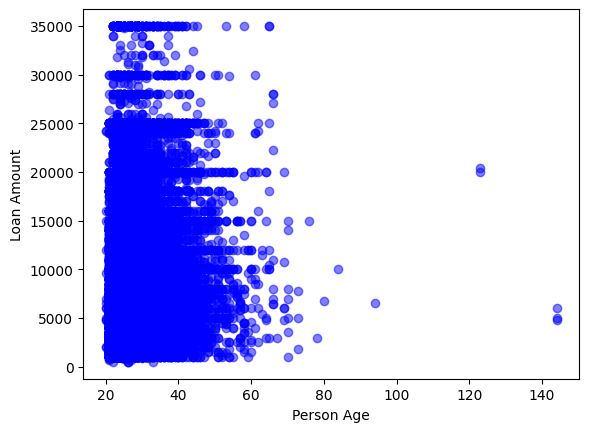

In [8]:
# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

## Replacing missing credit data
Now, you should check for missing data. If there are missing values in loan_status, the data can't be used to predict the probability of default because the default status would be unknown. Missing data in person_emp_length is less critical but can still lead to training errors.

Therefore, inspect the person_emp_length column for any missing values and replace them with the median.

Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

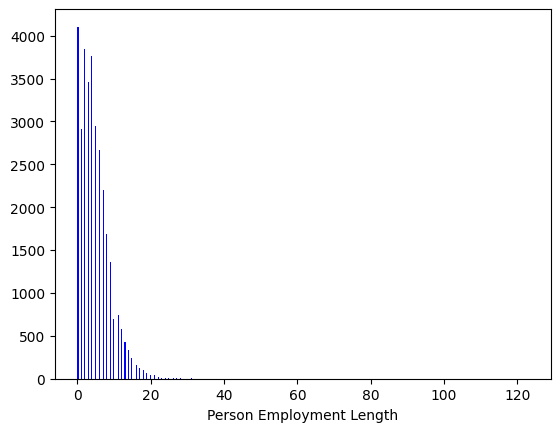

In [9]:
# Print a null value column array
print(cr_loan.columns[cr_loan.isnull().any()])

# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan['person_emp_length'].isnull()].head(5))

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

## Removing missing data
You have replaced the missing data in person_emp_length, but you also noticed that loan_int_rate has missing data.

Similar to loan_status, having missing data in loan_int_rate complicates predictions.

Since interest rates are set by your company, missing data in this column is unusual. This might be due to data ingestion errors, but the exact cause is uncertain. For now, it's best to drop these records using the .drop() method before proceeding.

In [11]:
# Print the number of nulls
print(cr_loan['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)
cr_loan_clean.to_csv('../data/interim/cr_loan_clean.csv', index=False)

3116


# Logistic Regression for Defaults

## Logistic regression basics
You have completed the data cleaning process and created a new dataset called cr_loan_clean.

Now, we create and train a logistic regression model using only loan_int_rate.

In [14]:
# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate']]
y = cr_loan_clean[['loan_status']]

# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression()
clf_logistic_single.fit(X, np.ravel(y))

# Print the parameters of the model
print(clf_logistic_single.get_params())

# Print the intercept of the model
print(clf_logistic_single.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[-4.4586918]


## Multivariate logistic regression
Since generally we want to use more than the loan_int_rate to predict the probability of default. 

Here, we will use all the data to make predictions. Now, we train a new model with different columns, called features, from the cr_loan_clean data.

In [15]:
# Create X data for the model
X_multi = cr_loan_clean[['loan_int_rate','person_emp_length']]

# Create a set of y data for training
y = cr_loan_clean[['loan_status']]

# Create and train a new logistic regression
clf_logistic_multi = LogisticRegression(solver='lbfgs').fit(X_multi, np.ravel(y))

# Print the intercept of the model
print(clf_logistic_multi.intercept_)

[-4.2253171]


## Creating training and test sets
The data should be separated into training and test sets. test_train_split() is used to create both at the same time. 

The training set is used to make predictions, while the test set is used for evaluation. Without evaluating the model, we have no way to tell how well it will perform on new loan data.

In addition to the intercept_, which is an attribute of the model, LogisticRegression() models also have the .coef_ attribute. This shows how important each training column is for predicting the probability of default.


In [17]:
# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 8.34020099e-02 -6.02470833e-02 -3.28983416e-05]]


## Changing coefficients
Let's fit two different LogisticRegression() models on different groups of columns to check how the coefficient changes and what the potential impact on the probability of default might be.

In [21]:
# Create the X and y data sets
X1 = cr_loan_clean[['person_income','person_emp_length','loan_amnt']]
X2 = cr_loan_clean[['person_income','loan_percent_income','cb_person_cred_hist_length']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=.4, random_state=123)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Print the first five rows of each training set
print(X1_train.head(5))
print(X2_train.head(5))

# Create and train a model on the first training data
clf_logistic1 = LogisticRegression(solver='lbfgs').fit(X1_train, np.ravel(y_train))

# Create and train a model on the second training data
clf_logistic2 = LogisticRegression(solver='lbfgs').fit(X2_train, np.ravel(y_train))

# Print the coefficients of each model
print(clf_logistic1.coef_)
print(clf_logistic2.coef_)

       person_income  person_emp_length  loan_amnt
25231          81900               13.0       8000
25262          47700                2.0      12000
21498          48000                6.0       5000
1774           19200                2.0       2000
11441          75000                7.0      10200
       person_income  loan_percent_income  cb_person_cred_hist_length
25231          81900                 0.10                          10
25262          47700                 0.25                           5
21498          48000                 0.10                          10
1774           19200                 0.10                           4
11441          75000                 0.14                           2
[[-4.12423659e-05 -2.25772815e-08  1.09365478e-04]]
[[-2.20252017e-05  1.90718041e-10 -1.75399456e-09]]


## One-hot encoding credit data
Prepare the non-numeric columns so they can be added to the LogisticRegression() model.

In [22]:
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(cr_loan_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


## Predicting probability of default
Train a LogisticRegression() model on the data, and examine how it predicts the probability of default.

In [23]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head(5)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            0      0.203595
1            0      0.137401
2            0      0.119622
3            0      0.307440
4            0      0.505785


## Default classification reporting
Here we set the threshold for probability of default to help us analyze the model's performance through classification reporting.

In [25]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

loan_status
0    10861
1      925
Name: count, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.81      0.96      0.88      9194
     Default       0.62      0.22      0.33      2592

    accuracy                           0.80     11786
   macro avg       0.72      0.59      0.61     11786
weighted avg       0.77      0.80      0.76     11786



## Selecting report metrics
Sometimes you just want specific values to compare models or use for other purposes.

There is a function within scikit-learn that pulls out the values for you. That function is precision_recall_fscore_support() and it takes in the same parameters as classification_report.

In [26]:
# Import function
from sklearn.metrics import precision_recall_fscore_support
# Select all non-averaged values from the report
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))


(array([0.81447381, 0.62378378]), array([0.96214923, 0.22260802]), array([0.88217402, 0.32812056]), array([9194, 2592]))
              precision    recall  f1-score   support

 Non-Default       0.81      0.96      0.88      9194
     Default       0.62      0.22      0.33      2592

    accuracy                           0.80     11786
   macro avg       0.72      0.59      0.61     11786
weighted avg       0.77      0.80      0.76     11786



## Visually scoring credit models
Here we visualize the performance of the model. In ROC charts, the X and Y axes are two metrics you've already looked at: the false positive rate (fall-out), and the true positive rate (sensitivity).

You can create a ROC chart of it's performance with the following code:

    fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
    plt.plot(fallout, sensitivity)

To calculate the AUC score, you use roc_auc_score().

The credit data cr_loan_prep along with the data sets X_test and y_test have all been loaded into the workspace. A trained LogisticRegression() model named clf_logistic has also been loaded into the workspace.

0.7995078907178008


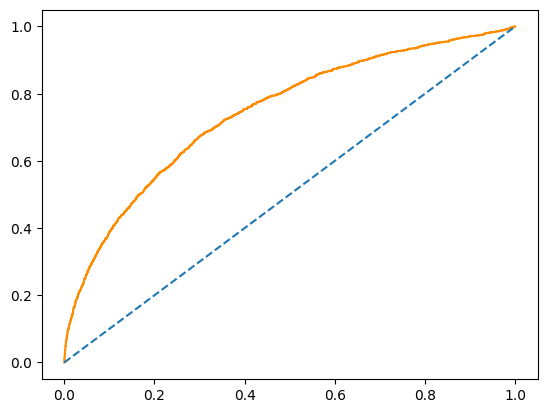

In [29]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)

# Print the accuracy score the model
print(clf_logistic.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

## Thresholds and confusion matrices
Set different values for the threshold on probability of default, and use a confusion matrix to see how the changing values affect the model's performance.

In [30]:
# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['loan_status']))

[[8846  348]
 [2015  577]]


## How thresholds affect performance
Setting the threshold to 0.4 shows promising results for model evaluation. Now we can assess the financial impact using the default recall which is selected from the classification reporting using the function precision_recall_fscore_support().

For this, we will estimate the amount of unexpected loss using the default recall to find what proportion of defaults we did not catch with the new threshold. This will be a dollar amount which tells you how much in losses we would have if all the unfound defaults were to default all at once.

In [31]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
avg_loan_amnt = cr_loan_clean['loan_amnt'].mean()
print(avg_loan_amnt * num_defaults * (1 - default_recall))

12206848.964421853


## Threshold selection
There is a trade off between metrics like default recall, non-default recall, and model accuracy. One easy way to approximate a good starting threshold value is to look at a plot of all three using matplotlib. 

With this graph, we can see how each of these metrics look when change the threshold values and find the point at which the performance of all three is good enough to use for the credit data.

In [ ]:
thresh = np.arange(0.2,0.675,.025)
ticks = np.arange(0.2,0.7,.05)
def_recalls = []
nondef_recalls = []
accs = []
ticks = np.arange(0,1,.1)

plt.plot(thresh,default_recall)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# Gradient Boosted Trees Using XGBoost

# Model Evaluation and Implementation